In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [480]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [536]:
zip_codes = crop_sim.load_zip("60601")
print(zip_codes)

     ZIP  latitude  longitude
0  60601   41.8858   -87.6181


In [505]:
# crop_sim.generate_near()

In [565]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [566]:
ecocrop_df = crop_sim.load_ecocrop()

In [567]:


# Select your crop of interest (replace 'Maize' with your desired crop)
crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
bolting = False
frost_tolerance = 0

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)

# tmax = 35

In [568]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [569]:
print(zip_codes['loca_index'].values)

[(30, 22)]


In [570]:
lat, lon = zip_codes['loca_index'].values[0]

In [571]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [572]:
import ephem
import datetime

observer = ephem.Observer()
observer.lat = str(zip_codes['latitude'].values[0])
observer.lon = str(zip_codes['longitude'].values[0])
observer.pressure = 0  # Disable atmospheric refraction for more accurate sunrise/sunset
sun = ephem.Sun()

start_date = datetime.date(2022, 1, 1)  # Start of the year
end_date = datetime.date(2024, 1, 1)  # End of the year
dates = []
day_lengths = []

current_date = start_date
while current_date <= end_date:
    observer.date = current_date
    try:
        sunrise = observer.next_rising(sun, use_center=True)  # Use center of the sun for accuracy
        sunset = observer.next_setting(sun, use_center=True)

        # Convert sunrise and sunset to local timezone
        sunrise = ephem.localtime(sunrise)#.replace(tzinfo=timezone)
        sunset = ephem.localtime(sunset)#.replace(tzinfo=timezone)

        # Ensure sunset is after sunrise
        if sunset < sunrise:
            sunset += datetime.timedelta(days=1)

        day_length = sunset - sunrise
        dates.append(current_date)
        day_lengths.append(day_length.total_seconds() / 3600)  # Convert to hours
    except ephem.AlwaysUpError:
        # Handle polar days
        dates.append(current_date)
        day_lengths.append(24)
    except ephem.NeverUpError:
        # Handle polar nights
        dates.append(current_date)
        day_lengths.append(0)
    current_date += datetime.timedelta(days=1)
    # try:
        
    #     current_datetime = datetime.datetime.combine(current_date, datetime.time(3, 0))  
    #     sunrise = sun.get_sunrise_time(current_datetime)
    #     sunset = sun.get_sunset_time(current_datetime)
    #     day_length = sunset - sunrise
    #     print([day_length, sunset, sunrise])
    #     dates.append(current_date)
    #     day_lengths.append(day_length.total_seconds() / 3600)  # Convert to hours
    # except SunTimeException:
    #     # Handle days without sunrise/sunset (e.g., polar regions)
    #     dates.append(current_date)
    #     day_lengths.append(0)  # Or some appropriate value
# print(day_lengths)
import numpy as np
day_lengths = np.array(day_lengths)

In [587]:
min_day = 13
max_day = 16
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, frost_tolerance)

In [588]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [589]:
cutoff = 0.1
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability, day_lengths, min_day, max_day)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon, cutoff)


In [590]:
view_window = 85
print(optimal_planting_ranges)

{85: [[Timestamp('2022-04-06 12:00:00'), Timestamp('2022-04-28 12:00:00')], [Timestamp('2023-04-08 12:00:00'), Timestamp('2023-04-18 12:00:00')]], 95: [[Timestamp('2022-04-06 12:00:00'), Timestamp('2022-04-18 12:00:00')]], 105: [], 115: [], 125: [], 135: [], 145: [], 155: [], 165: [], 175: []}


In [591]:
import matplotlib
matplotlib.pyplot.close()
optimal_planting_ranges[view_window]

[[Timestamp('2022-04-06 12:00:00'), Timestamp('2022-04-28 12:00:00')],
 [Timestamp('2023-04-08 12:00:00'), Timestamp('2023-04-18 12:00:00')]]

In [592]:
import crop_sim
import importlib
importlib.reload(crop_sim)
print(crop_sim.merge_overlapping_monthday_ranges(optimal_planting_ranges[view_window]))

[(4, 6, 4, 28)]


In [593]:
%matplotlib widget

In [594]:
import matplotlib

In [595]:
zip_codes['latitude'].values[0]

41.8858

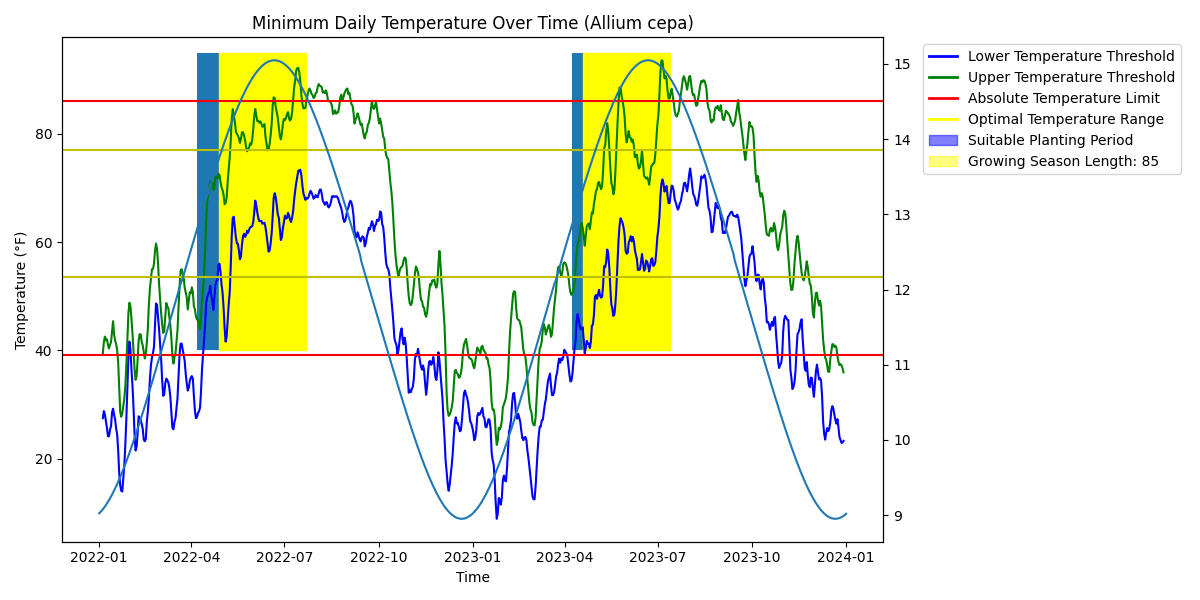

In [596]:
crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name, day_lengths, dates)


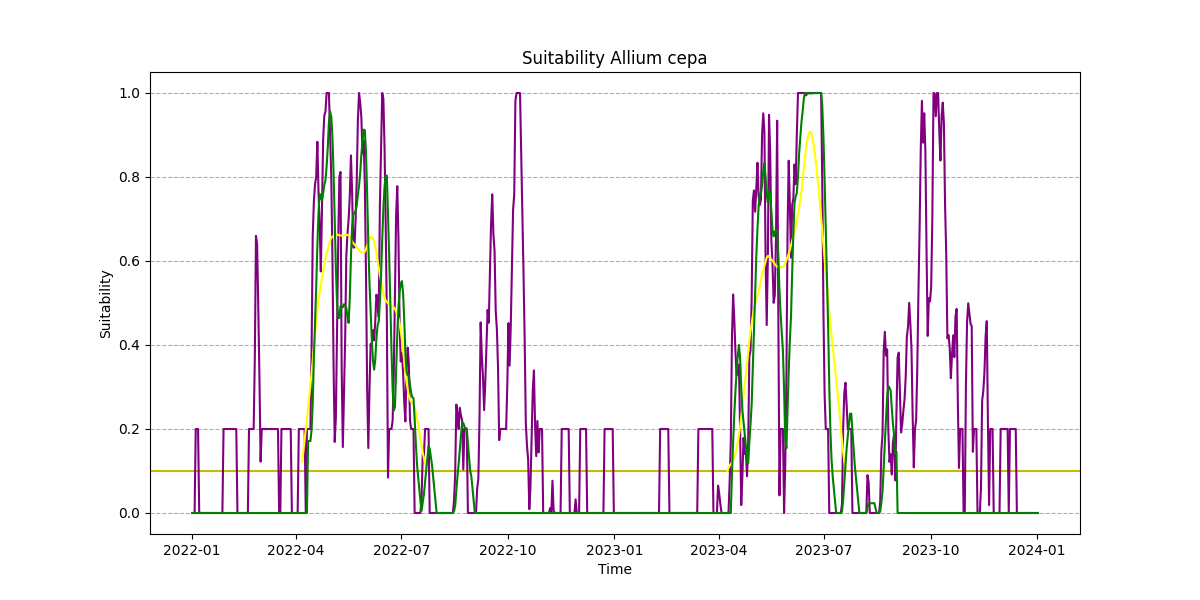

In [597]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name, cutoff)

In [598]:
suit = growing_season_suitability[view_window]
# x = suit.where(suit > 0)
# y = xr.where(suit > 0, suit, 0)
# x == y
# print(suit)

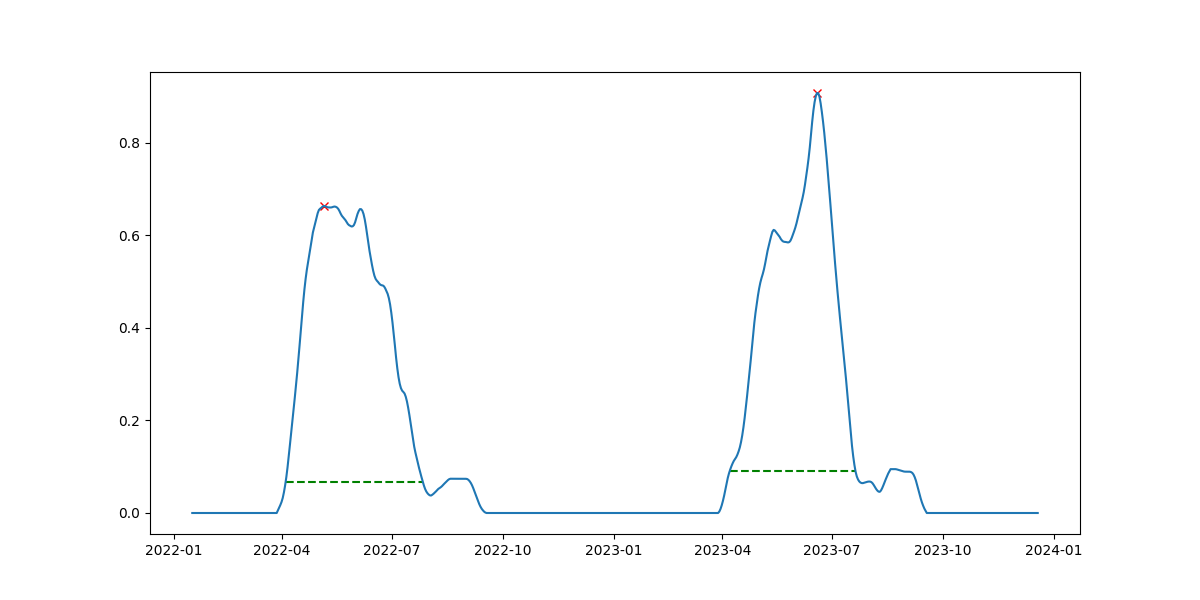

In [606]:
plt.subplots(figsize=(12, 6))
suit = growing_season_suitability[view_window]
suit = suit.rolling(time=30, center=True).mean()
# bef = suit
# aft = xr.where(suit < 0.01, 0, suit)
# suit = xr.where(suit > 0, suit, 0).where(suit < 1, suit, 0)
# a = xr.plot.hist(suit.isel(lat=lat,lon=lon))

from scipy.signal import find_peaks, peak_widths
import pandas as pd
x = suit.isel(lat=lat,lon=lon)
peaks, _ = find_peaks(x, width=view_window/2)  # Adjust as needed
# print(peaks)
peak_times = x.time[peaks].values
suitability_values = x.values.flatten()
# suitability_values = suitability_values[~np.isnan(suitability_values)]
plt.plot(peak_times, suitability_values[peaks], "x", color="red", label="Peaks")

widths, width_heights, left_ips, right_ips = peak_widths(
    suitability_values, peaks, rel_height=0.9
)  #

# Since xarray works with datetime, the peak widths must be converted to the same
left_edges = [peak_times[i] - pd.to_timedelta(abs(x - left_ips[i]), unit='D') for i, x in enumerate(peaks)]
right_edges = [peak_times[i] + pd.to_timedelta(abs(x - right_ips[i]), unit='D') for i, x in enumerate(peaks)]
# Plot peak widths as horizontal lines
plant_ranges = []
for left, right, height, widths in zip(left_edges, right_edges, width_heights, widths):
    right_adjusted = right + pd.to_timedelta(-view_window, unit="D")
    if left >= right_adjusted:
        pass
    else:
        plant_ranges.append([left, right_adjusted])
    plt.hlines(height, left, right, color="green", linestyle="--")

# plt.plot(suit.time, .isel(lat=lat,lon=lon), color="green")
plt.plot(suit.time, suit.isel(lat=lat,lon=lon))
# from scipy.signal import savgol_filter
# # Apply Savitzky-Golay filter
# window_length = 13  # Must be odd
# polyorder = 3

# smoothed_data = xr.apply_ufunc(
#     savgol_filter,
#     suit,
#     kwargs={"window_length": window_length, "polyorder": polyorder},
#     input_core_dims=[["time"]],
#     output_core_dims=[["time"]],  # Output is a single value per input
#     output_dtypes=[suit.dtype]
# )
# plt.plot(smoothed_data.isel(lat=lat,lon=lon))
plt.show()

In [607]:
print(crop_sim.merge_overlapping_monthday_ranges(plant_ranges))

[(4, 3, 5, 2)]


In [532]:
growing_season_suitability[view_window].isel(lat=lat,lon=lon).quantile(0.2)

<xarray.DataArray ()> Size: 8B
array(0.)
Coordinates:
    quantile  float64 8B 0.2

In [631]:
# import pandas as pd
# import xarray as xr
# tasmin = loca_tasmin.isel(lon=lon,lat=lat)
# # frost_days = pd.Series(tasmin < 273.15).rolling(window=7, min_periods=1).sum().to_numpy()
# frost_days = (tasmin < 273.15)

# # nippy_days = pd.Series(((tasmin < tmin + 273.15) & (tasmin > 273.15)).astype(int)).rolling(window=7, min_periods=1).sum().to_numpy()
# groups = frost_days.cumsum()
# group_sizes = groups.groupby(groups).count()
# max_consecutive_frost_days = 1
# extended_frost_mask = xr.ones_like(groups, dtype=bool)
# for group_number, size in group_sizes.to_pandas().items():  # Convert to Pandas for easier iteration
#     if size > max_consecutive_frost_days:
#         extended_frost_mask = xr.where(groups == group_number, False, extended_frost_mask)



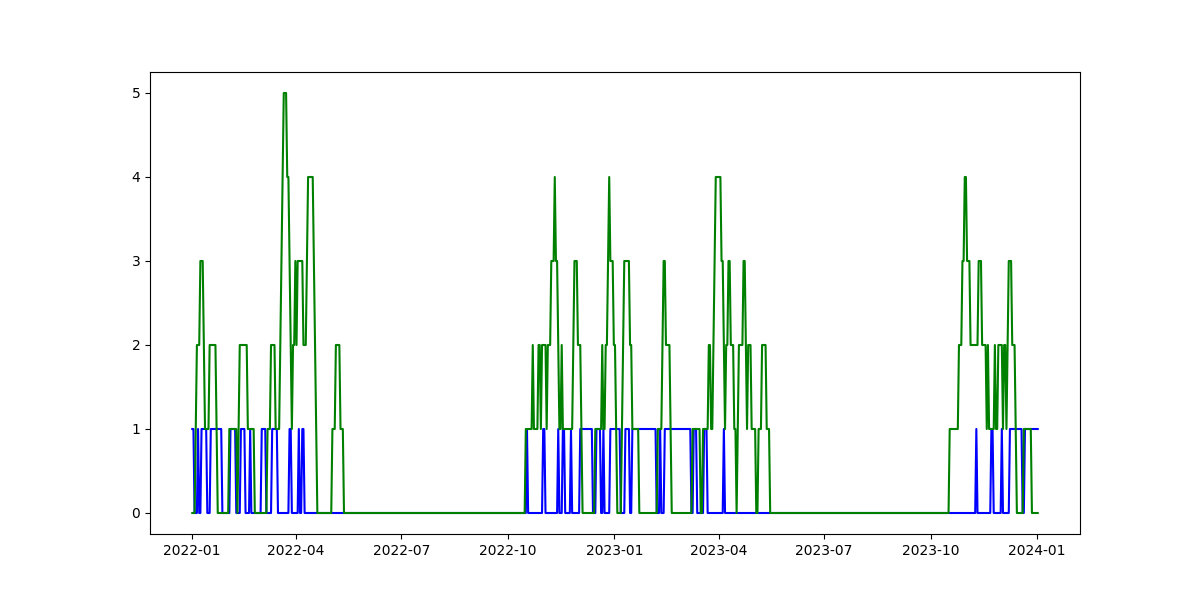

In [634]:
# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax1.plot(tasmin.time, extended_frost_mask, linestyle='-', color='blue')
# ax1.plot(tasmin.time, nippy_days, linestyle='-', color='green')
# plt.show()